<a href="https://colab.research.google.com/github/JossySoo/natural_language_processing_excercises/blob/main/Desafio_3/3_modelo_lenguaje_word.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Modelo de lenguaje con tokenización por palabras

### Consigna
- Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.
- Realizar el pre-procesamiento adecuado para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.
- Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.
- Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determístico y estocástico. En este último caso observar el efecto de la temperatura en la generación de secuencias.


### Sugerencias
- Durante el entrenamiento, guiarse por el descenso de la perplejidad en los datos de validación para finalizar el entrenamiento. Para ello se provee un callback.
- Explorar utilizar SimpleRNN (celda de Elman), LSTM y GRU.
- rmsprop es el optimizador recomendado para la buena convergencia. No obstante se pueden explorar otros.


# Ejemplo visto en clase

In [1]:
import random
import io
import pickle
import os
import platform

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy

### Datos
Como ejemplo se utilizará como corpus un dataset canciones de bandas de habla inglés.

In [2]:
# Descargar la carpeta de dataset
if os.access('./songs_dataset', os.F_OK) is False:
    if os.access('songs_dataset.zip', os.F_OK) is False:
        if platform.system() == 'Windows':
            !curl https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/datasets/songs_dataset.zip -o songs_dataset.zip
        else:
            !wget songs_dataset.zip https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/raw/main/datasets/songs_dataset.zip
    !unzip -q songs_dataset.zip
else:
    print("El dataset ya se encuentra descargado")

--2024-07-03 01:23:57--  http://songs_dataset.zip/
Resolving songs_dataset.zip (songs_dataset.zip)... failed: Name or service not known.
wget: unable to resolve host address ‘songs_dataset.zip’
--2024-07-03 01:23:57--  https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/raw/main/datasets/songs_dataset.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/datasets/songs_dataset.zip [following]
--2024-07-03 01:23:57--  https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/datasets/songs_dataset.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (

In [3]:
# Posibles bandas
os.listdir("./songs_dataset/")

['notorious_big.txt',
 'disney.txt',
 'johnny-cash.txt',
 'rihanna.txt',
 'bjork.txt',
 'kanye-west.txt',
 'bob-marley.txt',
 'blink-182.txt',
 'lorde.txt',
 'bob-dylan.txt',
 'ludacris.txt',
 'bruno-mars.txt',
 'lin-manuel-miranda.txt',
 'lady-gaga.txt',
 'michael-jackson.txt',
 'patti-smith.txt',
 'prince.txt',
 'r-kelly.txt',
 'lil-wayne.txt',
 'dr-seuss.txt',
 'eminem.txt',
 'bruce-springsteen.txt',
 'Kanye_West.txt',
 'joni-mitchell.txt',
 'cake.txt',
 'nursery_rhymes.txt',
 'alicia-keys.txt',
 'dj-khaled.txt',
 'drake.txt',
 'nirvana.txt',
 'beatles.txt',
 'paul-simon.txt',
 'missy-elliott.txt',
 'radiohead.txt',
 'jimi-hendrix.txt',
 'nicki-minaj.txt',
 'britney-spears.txt',
 'bieber.txt',
 'al-green.txt',
 'nickelback.txt',
 'dolly-parton.txt',
 'dickinson.txt',
 'amy-winehouse.txt',
 'janisjoplin.txt',
 'Lil_Wayne.txt',
 'adele.txt',
 'notorious-big.txt',
 'leonard-cohen.txt',
 'kanye.txt']

In [4]:
# Armar el dataset utilizando salto de línea para separar las oraciones/docs
df = pd.read_csv('songs_dataset/beatles.txt', sep='/n', header=None)
df.head()

<ipython-input-4-91c4bad52ba1>:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('songs_dataset/beatles.txt', sep='/n', header=None)


,0
0,"Yesterday, all my troubles seemed so far away"
1,Now it looks as though they're here to stay
2,"Oh, I believe in yesterday Suddenly, I'm not h..."
3,There's a shadow hanging over me.
4,"Oh, yesterday came suddenly Why she had to go ..."


Consideraremos que cada secuencia para este dataset es un verso.

Una de las primeras decisiones que hay que tomar es el tamaño de contexto de tokens máximo que puede consumir el modelo. Este podría ser un hiperparámetro del problema.

Para elegir el tamaño de contexto máximo para este problema se puede explorar el dataset, para ello:
- se consideran las palabras como términos.
- se segmentará el texto de todos los versos del dataset y ses explorará la cantidad de términos presentes.



In [5]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 1846


### Elegir el tamaño del contexto

In [6]:
# Usaremos las utilidades de procesamiento de textos y secuencias de Keras
from tensorflow.keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from tensorflow.keras.preprocessing.text import text_to_word_sequence # equivalente a word_tokenize de nltk
from tensorflow.keras.utils import pad_sequences # se utilizará para padding


In [7]:
# cada verso lo guardamos en una lista
text = list(df.loc[:,0])
text

['Yesterday, all my troubles seemed so far away',
 "Now it looks as though they're here to stay",
 "Oh, I believe in yesterday Suddenly, I'm not half the man I used to be",
 "There's a shadow hanging over me.",
 "Oh, yesterday came suddenly Why she had to go I don't know she wouldn't say",
 'I said something wrong, now I long for yesterday Yesterday, love was such an easy game to play',
 'Now I need a place to hide away',
 "Oh, I believe in yesterday Why she had to go I don't know she wouldn't say",
 'I said something wrong, now I long for yesterday Yesterday, love was such an easy game to play',
 'Now I need a place to hide away',
 'Oh, I believe in yesterday',
 'Mm mm mm mm mm mm mm When I find myself in times of trouble, Mother Mary comes to me',
 'Speaking words of wisdom, let it be',
 'And in my hour of darkness she is standing right in front of me',
 'Speaking words of wisdom, let it be',
 'Let it be, let it be, let it be, let it be',
 'Whisper words of wisdom, let it be And when

In [8]:
# segmentamos el texto con la utilidad de Keras
segmented_sentences = [text_to_word_sequence(sentence) for sentence in text]

In [9]:
text[0]

'Yesterday, all my troubles seemed so far away'

In [10]:
segmented_sentences[0]

['yesterday', 'all', 'my', 'troubles', 'seemed', 'so', 'far', 'away']

In [11]:
# calculamos la longitud de cada secuencia
length_sentences = [len(sentence) for sentence in segmented_sentences]

(array([ 29., 305., 221., 523., 293.,  72., 180.,  97.,  42.,  39.,  22.,
         12.,   4.,   3.,   0.,   0.,   2.,   1.,   0.,   1.]),
 array([ 1.  ,  2.65,  4.3 ,  5.95,  7.6 ,  9.25, 10.9 , 12.55, 14.2 ,
        15.85, 17.5 , 19.15, 20.8 , 22.45, 24.1 , 25.75, 27.4 , 29.05,
        30.7 , 32.35, 34.  ]),
 <BarContainer object of 20 artists>)

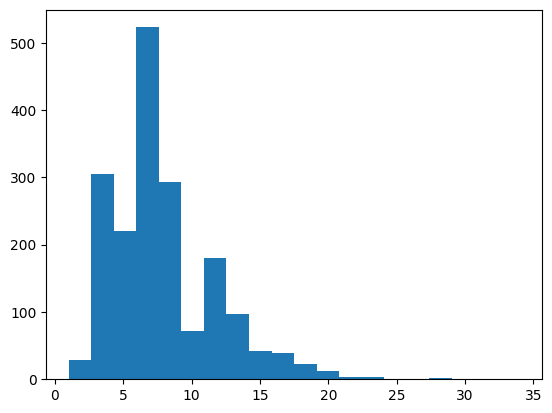

In [12]:
# podemos ver su distribución
plt.hist(length_sentences,bins=20)

In [13]:
# a partir de la distribución de longitudes de secuencias elegimos algún criterio
# para determinar el máximo tamaño de contexto. En este caso es un percentil, pero
# otros criterios también pueden ser válidos con la justificación adecuada.
# También puede ser una selección "a mano"

# el -1 es porque el último token será el target
max_context_size = int(np.percentile(length_sentences, 90)-1)

# max_context_size = int(np.ceil(np.mean(length_sentences))) # criterio de media
# max_context_size = int(np.ceil(np.median(length_sentences))) # criterio de mediana
print(f'max_context_size: {max_context_size}')

max_context_size: 12


###  Tokenizar

In [14]:
# instanciamos el tokenizador
tok = Tokenizer()

# El tokenizer "aprende" las palabras que se usaran
# Se construye (fit) una vez por proyecto, se aplica N veces (tal cual un encoder)
# El token 0 es reservado y no es asignado. Se utiliza para designar a palabras
# fuera del vocabulario aprendido
tok.fit_on_texts(segmented_sentences)

# Convertimos las palabras a números
# entran palabras -> salen números
tokenized_sentences = tok.texts_to_sequences(segmented_sentences)

In [15]:
tokenized_sentences[0]

[200, 10, 12, 907, 908, 42, 909, 121]

In [16]:
segmented_sentences[0]

['yesterday', 'all', 'my', 'troubles', 'seemed', 'so', 'far', 'away']

### Organizando y estructurando el dataset

En este punto tenemos en la variable `tokenized_sentences` los versos tokenizados. Vamos a quedarnos con un conjunto de validación que utilizaremos para medir la calidad de la generación de secuencias con la métrica de Perplejidad.

In [17]:
tokenized_sentences_train, tokenized_sentences_val, _, _ = train_test_split(tokenized_sentences, tokenized_sentences, test_size=0.2, random_state=42)

\Vamos a splitear las oraciones que tienen tamaño mayor al contexto máximo, para generarnos más secuencias de entrenamiento. Este paso puede obviarse si el tamaño de contexto máximo es muy grande.

Por ejemplo, si tenemos el texto *La bella y graciosa moza marchóse a lavar la ropa* y nuestro contexto es de 5 palabras, tendremos:

- *La bella y graciosa moza*
- *bella y graciosa moza marchóse*
- *y graciosa moza marchóse a*
- *graciosa moza marchóse a lavar*
- *moza marchóse a lavar la*
- *marchóse a lavar la ropa*

In [18]:
tok_sent = []

for sent in tokenized_sentences_train:

  # si la secuencia tiene más términos que el tamaño de contexto máximo,
  # armo varias sub-secuencias de tamaño máximo
  if len(sent) > (max_context_size+1):
    extra = len(sent)-(max_context_size+1) + 1
    for i in range(extra):
      tok_sent.append(sent[i:i+max_context_size+1])
  else: # si la secuencia tiene menos términos el tamaño de contexto máximo, dejo la secuencia como está
    tok_sent.append(sent)


In [19]:
len(tok_sent)

1957

Ahora aumentamos los datos aprovechando que de una secuencia grande se pueden generar varias más pequeñas:

- *La hermosa casa en el prado*
- *La hermosa*
- *La hermosa casa*
- *La hermosa casa en*
- *La hermosa casa en el*
- *La hermosa casa en el prado*

In [20]:
tok_sent_augm = []

for sent in tok_sent:

  # generamos todas las sub-secuencias
  subseq = [sent[:i+2] for i in range(len(sent)-1)]
  # en esta línea paddeamos al tamaño de contexto máximo
  tok_sent_augm.append(pad_sequences(subseq, maxlen=max_context_size+1, padding='pre'))


In [21]:
# finalmente concatenamos todas las secuencias en un único array de numpy
train_seqs = np.concatenate(tok_sent_augm, axis=0)

In [22]:
train_seqs.shape

(15325, 13)

In [23]:
# y de aquí sacamos las entradas y los targets que consumirá nuestro sistema en
# tiempo de entrenamiento
X = train_seqs[:,:-1]
y = train_seqs[:,1:]

Nótese que estamos estructurando el problema de aprendizaje como *many-to-many*:

Entrada: secuencia de tokens [$x_0$, $x_1$, ..., $x_N$]

Target: secuencia de tokens [$x_1$, $x_2$, ..., $x_{N+1}$]

De manera que la red tiene que aprender que su salida deben ser los tokens desplazados en una posición y un nuevo token predicho (el N+1).

La ventaja de estructurar el aprendizaje de esta manera es que para cada token de target se propaga una señal de gradiente por el grafo de cómputo recurrente, que es mejor que estructurar el problema como *many-to-one* en donde sólo una señal de gradiente se propaga.

In [24]:
y.shape

(15325, 12)

In [25]:
# Palabras del vocabulario
tok.index_word

{1: 'you',
 2: 'i',
 3: 'the',
 4: 'to',
 5: 'and',
 6: 'love',
 7: 'a',
 8: 'me',
 9: 'in',
 10: 'all',
 11: 'nah',
 12: 'my',
 13: 'it',
 14: 'know',
 15: 'be',
 16: 'that',
 17: 'of',
 18: 'on',
 19: 'she',
 20: 'is',
 21: 'say',
 22: 'now',
 23: 'oh',
 24: 'yeah',
 25: 'your',
 26: 'get',
 27: "don't",
 28: 'back',
 29: 'let',
 30: 'with',
 31: 'her',
 32: 'can',
 33: "it's",
 34: 'do',
 35: "i'm",
 36: 'when',
 37: 'come',
 38: 'will',
 39: 'he',
 40: 'but',
 41: 'for',
 42: 'so',
 43: 'need',
 44: 'there',
 45: 'like',
 46: 'no',
 47: 'together',
 48: "i'll",
 49: 'see',
 50: 'was',
 51: 'never',
 52: 'we',
 53: 'down',
 54: 'way',
 55: 'if',
 56: 'want',
 57: 'out',
 58: 'hey',
 59: 'one',
 60: 'got',
 61: 'go',
 62: 'well',
 63: "can't",
 64: 'girl',
 65: 'good',
 66: 'his',
 67: 'sun',
 68: 'they',
 69: 'home',
 70: 'hello',
 71: 'day',
 72: 'are',
 73: 'ah',
 74: 'right',
 75: 'little',
 76: 'at',
 77: 'from',
 78: 'man',
 79: 'here',
 80: 'help',
 81: 'gonna',
 82: 'have',
 

In [26]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

1628

In [27]:
# El índice para cada palabra
# El sistema las ordena de las más populares a las menos populares
print(tok.word_index)

{'you': 1, 'i': 2, 'the': 3, 'to': 4, 'and': 5, 'love': 6, 'a': 7, 'me': 8, 'in': 9, 'all': 10, 'nah': 11, 'my': 12, 'it': 13, 'know': 14, 'be': 15, 'that': 16, 'of': 17, 'on': 18, 'she': 19, 'is': 20, 'say': 21, 'now': 22, 'oh': 23, 'yeah': 24, 'your': 25, 'get': 26, "don't": 27, 'back': 28, 'let': 29, 'with': 30, 'her': 31, 'can': 32, "it's": 33, 'do': 34, "i'm": 35, 'when': 36, 'come': 37, 'will': 38, 'he': 39, 'but': 40, 'for': 41, 'so': 42, 'need': 43, 'there': 44, 'like': 45, 'no': 46, 'together': 47, "i'll": 48, 'see': 49, 'was': 50, 'never': 51, 'we': 52, 'down': 53, 'way': 54, 'if': 55, 'want': 56, 'out': 57, 'hey': 58, 'one': 59, 'got': 60, 'go': 61, 'well': 62, "can't": 63, 'girl': 64, 'good': 65, 'his': 66, 'sun': 67, 'they': 68, 'home': 69, 'hello': 70, 'day': 71, 'are': 72, 'ah': 73, 'right': 74, 'little': 75, 'at': 76, 'from': 77, 'man': 78, 'here': 79, 'help': 80, 'gonna': 81, 'have': 82, 'not': 83, 'world': 84, 'going': 85, 'what': 86, 'still': 87, 'how': 88, 'too': 89

In [28]:
# Cantidad de veces quea aparece cada palabra en cada "documento"
# (1 documento = 1 caso de entrada)
print(tok.word_docs)

defaultdict(<class 'int'>, {'away': 21, 'my': 134, 'seemed': 1, 'all': 177, 'far': 1, 'troubles': 1, 'yesterday': 10, 'so': 61, 'it': 125, 'stay': 7, "they're": 5, 'as': 25, 'now': 90, 'though': 11, 'to': 307, 'looks': 2, 'here': 33, 'in': 186, 'i': 400, 'oh': 77, 'used': 1, 'be': 108, 'suddenly': 3, "i'm": 66, 'man': 34, 'not': 32, 'the': 376, 'half': 1, 'believe': 15, 'hanging': 1, 'shadow': 1, 'a': 270, 'over': 5, 'me': 219, "there's": 14, 'came': 11, 'know': 132, 'why': 20, 'she': 90, "wouldn't": 4, 'had': 19, 'go': 38, "don't": 74, 'say': 76, 'for': 62, 'play': 10, 'game': 3, 'such': 9, 'an': 15, 'something': 13, 'love': 181, 'wrong': 6, 'long': 25, 'easy': 9, 'said': 14, 'was': 48, 'need': 51, 'place': 10, 'hide': 13, 'mm': 3, 'times': 5, 'of': 109, 'comes': 20, 'myself': 3, 'mother': 2, 'trouble': 1, 'mary': 2, 'find': 10, 'when': 71, 'speaking': 4, 'wisdom': 7, 'let': 55, 'words': 14, 'standing': 13, 'hour': 1, 'is': 89, 'front': 1, 'and': 311, 'darkness': 1, 'right': 25, 'hear


### Definir el modelo

In [29]:
model = Sequential()

# la primera capa es de embedding entrenable. Recordar que se puede variar el tamaño
# del embedding a entrenar
model.add(Embedding(input_dim=vocab_size+1, output_dim=50, input_shape=(None,)))

model.add(LSTM(100, return_sequences=True))
# model.add(Dropout(0.2))

model.add(LSTM(100, return_sequences=True))
# model.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax
# La salida es del tamaño del vocabulario
model.add(Dense(vocab_size+1, activation='softmax'))


# Clasificación multiple categórica --> loss = categorical_crossentropy
# notar que usamos la versión Sparse para utilizar sólo índices en lugar de OHE
model.compile(loss=SparseCategoricalCrossentropy(), optimizer='rmsprop')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 50)          81450     
                                                                 
 lstm (LSTM)                 (None, None, 100)         60400     
                                                                 
 lstm_1 (LSTM)               (None, None, 100)         80400     
                                                                 
 dense (Dense)               (None, None, 1629)        164529    
                                                                 
Total params: 386779 (1.48 MB)
Trainable params: 386779 (1.48 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Dado que por el momento no hay implementaciones adecuadas de la perplejidad que puedan operar en tiempo de entrenamiento, armaremos un Callback *ad-hoc* que la calcule en cada epoch.

**Nota**: un Callback es una rutina gatillada por algún evento, son muy útiles para relevar datos en diferentes momentos del desarrollo del modelo. En este caso queremos hacer un cálculo cada vez que termina una epoch de entrenamiento.

In [176]:
class PplCallback(keras.callbacks.Callback):

    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    Además implementa la finalización del entrenamiento (Early Stopping)
    si la perplejidad no mejora después de `patience` epochs.
    '''

    def __init__(self, val_data, history_ppl, patience=8):
      # El callback lo inicializamos con secuencias de validación sobre las cuales
      # mediremos la perplejidad y la paciencia para detener el entrenamiento.
      self.val_data = val_data

      self.target = []
      self.padded = []

      count = 0
      self.info = []
      self.history_ppl = []
      self.min_score = np.inf
      self.patience_counter = 0
      self.patience = patience

      # nos movemos en todas las secuencias de los datos de validación
      for seq in self.val_data:

        len_seq = len(seq)
        # armamos todas las subsecuencias
        subseq = [seq[:i] for i in range(len_seq)]
        self.target.extend([seq[i] for i in range(len_seq)])

        if len(subseq)!=0:

          self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))

          self.info.append((count,count+len_seq))
          count += len_seq

      self.padded = np.vstack(self.padded)


    def on_epoch_end(self, epoch, logs=None):

        # en `scores` iremos guardando la perplejidad de cada secuencia
        scores = []

        predictions = self.model.predict(self.padded,verbose=0)

        # para cada secuencia de validación
        for start,end in self.info:

          # en `probs` iremos guardando las probabilidades de los términos target
          probs = [predictions[idx_seq,-1,idx_vocab] for idx_seq, idx_vocab in zip(range(start,end),self.target[start:end])]

          # calculamos la perplejidad por medio de logaritmos
          scores.append(np.exp(-np.sum(np.log(probs))/(end-start)))

        # promediamos todos los scores e imprimimos el valor promedio
        current_score = np.mean(scores)
        history_ppl.append(current_score)
        print(f'\n mean perplexity: {current_score} \n')

        # chequeamos si tenemos que detener el entrenamiento
        if current_score < self.min_score:
          self.min_score = current_score
          self.model.save("my_model")
          print("Saved new model!")
          self.patience_counter = 0
        else:
          self.patience_counter += 1
          if self.patience_counter == self.patience:
            print("Stopping training...")
            self.model.stop_training = True


### Entrenamiento

In [31]:
# fiteamos, nótese el agregado del callback con su inicialización. El batch_size lo podemos seleccionar a mano
# en general, lo mejor es escoger el batch más grande posible que minimice el tiempo de cada época.
# En la variable `history_ppl` se guardarán los valores de perplejidad para cada época.
history_ppl = []
hist = model.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl)], batch_size=64)

Epoch 1/20
240/240 [==============================] - ETA: 0s - loss: 4.1260
 mean perplexity: 3112.3240458745945 

Saved new model!
240/240 [==============================] - 18s 60ms/step - loss: 4.1260
Epoch 2/20
240/240 [==============================] - ETA: 0s - loss: 3.2335
 mean perplexity: 2960.038272095359 

Saved new model!
240/240 [==============================] - 8s 33ms/step - loss: 3.2335
Epoch 3/20
240/240 [==============================] - ETA: 0s - loss: 3.0942
 mean perplexity: 2656.977921556085 

Saved new model!
240/240 [==============================] - 8s 35ms/step - loss: 3.0942
Epoch 4/20
240/240 [==============================] - ETA: 0s - loss: 3.0621
 mean perplexity: 3258.7397206671253 

240/240 [==============================] - 2s 8ms/step - loss: 3.0621
Epoch 5/20
240/240 [==============================] - ETA: 0s - loss: 3.0501
 mean perplexity: 2462.9419283890825 

Saved new model!
240/240 [==============================] - 8s 34ms/step - loss: 3.0501

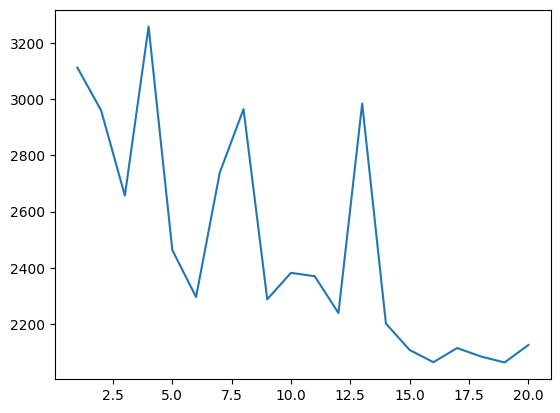

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# Podemos graficar la evolución de la perplejidad con las épocas.
# Recordar que el valor de perplejidad del modelo trivial es el tamaño del vocabulario.
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl)
plt.show()

In [33]:
# Cargamos el mejor modelo guardado del entrenamiento para hacer inferencia
model = keras.models.load_model('my_model')


### Predicción de próxima palabra

In [34]:
# Se puede usar gradio para probar el modelo
# Gradio es una herramienta muy útil para crear interfaces para ensayar modelos
# https://gradio.app/

!pip install -q gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 91.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 13.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.2/318.2 kB 38.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 82.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 7.5 M

In [35]:
"""import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=max_context_size, padding='pre')

    # Predicción softmax
    y_hat = np.argmax(model.predict(encoded)[0,-1,:])


    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text")

iface.launch(debug=True)"""

'import gradio as gr\n\ndef model_response(human_text):\n\n    # Encodeamos\n    encoded = tok.texts_to_sequences([human_text])[0]\n    # Si tienen distinto largo\n    encoded = pad_sequences([encoded], maxlen=max_context_size, padding=\'pre\')\n\n    # Predicción softmax\n    y_hat = np.argmax(model.predict(encoded)[0,-1,:])\n\n\n    # Debemos buscar en el vocabulario la palabra\n    # que corresopnde al indice (y_hat) predicho por le modelo\n    out_word = \'\'\n    for word, index in tok.word_index.items():\n        if index == y_hat:\n            out_word = word\n            break\n\n    # Agrego la palabra a la frase predicha\n    return human_text + \' \' + out_word\n\niface = gr.Interface(\n    fn=model_response,\n    inputs=["textbox"],\n    outputs="text")\n\niface.launch(debug=True)'

### Generación de secuencias

In [36]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	  # generate a fixed number of words
    for _ in range(n_words):
		  # Tokenizamos
      encoded = tokenizer.texts_to_sequences([output_text])[0]

		  # Si tienen distinto largo
      encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		  # Predicción softmax
      y_hat = np.argmax(model.predict(encoded)[0,-1,:])

      # Vamos concatenando las predicciones
      out_word = ''

      # Debemos buscar en el vocabulario la palabra
      # que corresopnde al indice (y_hat) predicho por le modelo
      for word, index in tokenizer.word_index.items():
        if index == y_hat:
          out_word = word
          break

		  # Agrego las palabras a la frase predicha
      output_text += ' ' + out_word

    return output_text

In [37]:
input_text='hey jude don\'t'

generate_seq(model, tok, input_text, max_length=max_context_size, n_words=10)

1/1 [==============================] - 0s 21ms/step


"hey jude don't need me love you love you love you love you"

###  Beam search y muestreo aleatorio

In [38]:
# funcionalidades para hacer encoding y decoding

def encode(text,max_length=max_context_size):

    encoded = tok.texts_to_sequences([text])[0]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return tok.sequences_to_texts([seq])

In [39]:
from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp,mode):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  if mode == 'det':
    idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  elif mode == 'sto':
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo aleatorio
  else:
    raise ValueError(f'Wrong selection mode. {mode} was given. det and sto are supported.')

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input,temp=1,mode='det'):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = model.predict(encoded,verbose=0)[0,-1,:]

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens,
                                        temp,
                                        mode)

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = model.predict(input_update,verbose=0)[0,-1,:]

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens,
                                                        temp,
                                                        mode)

    return history_tokens

In [40]:
# predicción con beam search.
# Se pueden camiar los modos entre 'det' (determinista) y
# 'sto' (estocástico)
# para el caso estocástico también se puede variar la temperatura
salidas = beam_search(model,num_beams=10,num_words=6,input="when i find myself in times",temp=1,mode='sto')

In [41]:
# tenemos `num_beams` salidas ordenadas de mayor a menor likelihood
salidas.shape

(10, 18)

In [42]:
# veamos las salidas
decode(salidas[0])

["when i find myself in times in a broken day's night from"]

# Desarrollo del TP

## Cargar corpus

In [43]:
# Verifica si el archivo PDF ya está descargado
if os.access('./Jane Austen - Orgullo y Prejuicio.pdf', os.F_OK) is False:
    # Verifica si el archivo PDF ya está descargado
    if os.access('orgullo_y_prejuicio.pdf', os.F_OK) is False:
        # Descargar el archivo según el sistema operativo
        if platform.system() == 'Windows':
            !curl -L -o orgullo_y_prejuicio.pdf https://github.com/JossySoo/natural_language_processing_excercises/raw/main/Data/Jane%20Austen%20-%20Orgullo%20y%20Prejuicio.pdf
        else:
            !wget -O orgullo_y_prejuicio.pdf https://github.com/JossySoo/natural_language_processing_excercises/raw/main/Data/Jane%20Austen%20-%20Orgullo%20y%20Prejuicio.pdf
else:
    print("El PDF ya se encuentra descargado")

In [44]:
print("Tamaño del archivo descargado:", os.path.getsize("orgullo_y_prejuicio.pdf"), "bytes")

Tamaño del archivo descargado: 609042 bytes


In [45]:
!pip install pymupdf

In [46]:
import fitz  # PyMuPDF

# Leer el PDF y extraer el texto
pdf_document = "orgullo_y_prejuicio.pdf"
doc = fitz.open(pdf_document)
text = ""
for page_num in range(doc.page_count):
    page = doc.load_page(page_num)
    text += page.get_text()

# Mostrar el texto extraído (opcional)
print(text[:1000])  # Muestra los primeros 1000 caracteres

# Guardar el texto extraído en un archivo de texto
with open("orgullo_y_prejuicio.txt", "w", encoding="utf-8") as text_file:
    text_file.write(text)

Orgullo y Prejuicio
Jane Austen
textos.info
Biblioteca digital abierta
1
Texto núm. 3006
Título: Orgullo y Prejuicio
Autor: Jane Austen
Etiquetas: Novela
Editor: Edu Robsy
Fecha de creación: 7 de noviembre de 2017
Fecha de modificación: 7 de noviembre de 2017
Edita textos.info
Maison Carrée
c/ Ramal, 48
07730 Alayor - Menorca
Islas Baleares
España
Más textos disponibles en http://www.textos.info
2
Capítulo I
Es una verdad mundialmente reconocida que un hombre soltero, poseedor 
de una gran fortuna, necesita una esposa.
Sin embargo, poco se sabe de los sentimientos u opiniones de un hombre 
de tales condiciones cuando entra a formar parte de un vecindario. Esta 
verdad está tan arraigada en las mentes de algunas de las familias que lo 
rodean, que algunas le consideran de su legítima propiedad y otras de la 
de sus hijas.
—Mi querido señor Bennet —le dijo un día su esposa—, ¿sabías que, por 
fin, se ha alquilado Netherfield Park?
El señor Bennet respondió que no.
—Pues así es —insistió 

In [47]:
import re

# Leer el archivo de texto
with open("orgullo_y_prejuicio.txt", "r", encoding="utf-8") as file:
    text = file.read()

# Limpieza básica del texto
text = text.lower()
text = re.sub(r'\s+', ' ', text)  # Reemplaza múltiples espacios por uno solo
text = re.sub(r'[^a-záéíóúüñ\s.?!]', '', text)  # Elimina caracteres no alfabéticos excepto vocales con tildes y eñes

# Separar el texto en oraciones usando el punto como delimitador
sentences = re.split(r'(?<=[.?!])\s+', text)

# Guardar cada oración en una nueva línea
with open("orgullo_y_prejuicio_clean.txt", "w", encoding="utf-8") as text_file:
    for sentence in sentences:
        text_file.write(sentence + '\n')

In [48]:
# Leer el archivo de texto línea por línea usando pandas
df = pd.read_csv('orgullo_y_prejuicio_clean.txt', sep='/n', header=None, names=['sentence'])
print(df.head(25))

                                             sentence
0   orgullo y prejuicio jane austen textos.info bi...
1   título orgullo y prejuicio autor jane austen e...
2   sin embargo poco se sabe de los sentimientos u...
3   esta verdad está tan arraigada en las mentes d...
4   mi querido señor bennet le dijo un día su espo...
5                   el señor bennet respondió que no.
6   pues así es insistió ella la señora long ha es...
7        el señor bennet no hizo ademán de contestar.
8             no quieres saber quién lo ha alquilado?
9                            se impacientó su esposa.
10  eres tú la que quieres contármelo y yo no teng...
11                 esta sugerencia le fue suficiente.
12  pues sabrás querido que la señora long dice qu...
13                                     cómo se llama?
14                                           bingley.
15                             está casado o soltero?
16                                                oh!
17                      solt

<ipython-input-48-1cab1fe38691>:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('orgullo_y_prejuicio_clean.txt', sep='/n', header=None, names=['sentence'])


In [49]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 6185


## Elegir tamaño del contexto

In [73]:
# Usaremos las utilidades de procesamiento de textos y secuencias de Keras
from tensorflow.keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from tensorflow.keras.preprocessing.text import text_to_word_sequence # equivalente a word_tokenize de nltk
from tensorflow.keras.utils import pad_sequences # se utilizará para padding

In [74]:
# cada verso lo guardamos en una lista
text = list(df.iloc[:,0])
text

['orgullo y prejuicio jane austen textos.info biblioteca digital abierta  texto núm.',
 'título orgullo y prejuicio autor jane austen etiquetas novela editor edu robsy fecha de creación  de noviembre de  fecha de modificación  de noviembre de  edita textos.info maison carrée c ramal   alayor  menorca islas baleares españa más textos disponibles en httpwww.textos.info  capítulo i es una verdad mundialmente reconocida que un hombre soltero poseedor de una gran fortuna necesita una esposa.',
 'sin embargo poco se sabe de los sentimientos u opiniones de un hombre de tales condiciones cuando entra a formar parte de un vecindario.',
 'esta verdad está tan arraigada en las mentes de algunas de las familias que lo rodean que algunas le consideran de su legítima propiedad y otras de la de sus hijas.',
 'mi querido señor bennet le dijo un día su esposa sabías que por fin se ha alquilado netherfield park?',
 'el señor bennet respondió que no.',
 'pues así es insistió ella la señora long ha estado

In [75]:
# segmentamos el texto con la utilidad de Keras
segmented_sentences = [text_to_word_sequence(sentence) for sentence in text]

In [76]:
segmented_sentences[3]

['esta',
 'verdad',
 'está',
 'tan',
 'arraigada',
 'en',
 'las',
 'mentes',
 'de',
 'algunas',
 'de',
 'las',
 'familias',
 'que',
 'lo',
 'rodean',
 'que',
 'algunas',
 'le',
 'consideran',
 'de',
 'su',
 'legítima',
 'propiedad',
 'y',
 'otras',
 'de',
 'la',
 'de',
 'sus',
 'hijas']

In [77]:
# calculamos la longitud de cada secuencia
length_sentences = [len(sentence) for sentence in segmented_sentences]

(array([1143., 1215., 1021.,  811.,  568.,  477.,  310.,  216.,  142.,
          87.,   81.,   38.,   22.,   21.,   12.,   11.,    3.,    2.,
           0.,    5.]),
 array([  1. ,   6.2,  11.4,  16.6,  21.8,  27. ,  32.2,  37.4,  42.6,
         47.8,  53. ,  58.2,  63.4,  68.6,  73.8,  79. ,  84.2,  89.4,
         94.6,  99.8, 105. ]),
 <BarContainer object of 20 artists>)

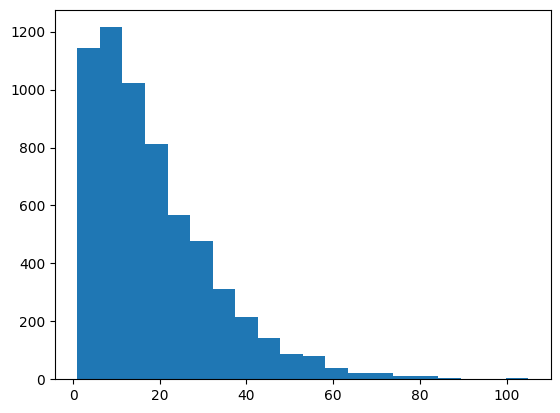

In [78]:
# podemos ver su distribución
plt.hist(length_sentences,bins=20)

In [79]:
# a partir de la distribución de longitudes de secuencias elegimos algún criterio
# para determinar el máximo tamaño de contexto. En este caso es un percentil.

# el -1 es porque el último token será el target
# Reducimos la ventana de contexto por problemas con la memoria del GPU
max_context_size = int(np.percentile(length_sentences, 50)-1)
print(f'max_context_size: {max_context_size}')

max_context_size: 14


## Tokenizar

In [80]:
# instanciamos el tokenizador
tok = Tokenizer()

# El tokenizer "aprende" las palabras que se usaran
# Se construye (fit) una vez por proyecto, se aplica N veces (tal cual un encoder)
# El token 0 es reservado y no es asignado. Se utiliza para designar a palabras
# fuera del vocabulario aprendido
tok.fit_on_texts(segmented_sentences)

# Convertimos las palabras a números
# entran palabras -> salen números
tokenized_sentences = tok.texts_to_sequences(segmented_sentences)

In [81]:
tokenized_sentences[3]

[98,
 220,
 132,
 32,
 3419,
 7,
 21,
 5105,
 1,
 435,
 1,
 21,
 989,
 2,
 12,
 5106,
 2,
 435,
 14,
 3420,
 1,
 8,
 3421,
 1152,
 5,
 287,
 1,
 3,
 1,
 28,
 153]

In [82]:
segmented_sentences[3]

['esta',
 'verdad',
 'está',
 'tan',
 'arraigada',
 'en',
 'las',
 'mentes',
 'de',
 'algunas',
 'de',
 'las',
 'familias',
 'que',
 'lo',
 'rodean',
 'que',
 'algunas',
 'le',
 'consideran',
 'de',
 'su',
 'legítima',
 'propiedad',
 'y',
 'otras',
 'de',
 'la',
 'de',
 'sus',
 'hijas']

## Organizando y estructurando el dataset

In [213]:
# Dividimos el dataset por problemas con la memoria del GPU
tokenized_sentences_1, tokenized_sentences_2, _, _ = train_test_split(tokenized_sentences, tokenized_sentences, test_size=0.4, random_state=10)

# Separamos sets de entrenamiento y validación
tokenized_sentences_train, tokenized_sentences_val, _, _ = train_test_split(tokenized_sentences_1, tokenized_sentences_1, test_size=0.2, random_state=42)


In [214]:
# Separamos las oraciones de mayor tamaño

tok_sent = []

for sent in tokenized_sentences_train:

  # si la secuencia tiene más términos que el tamaño de contexto máximo,
  # armo varias sub-secuencias de tamaño máximo
  if len(sent) > (max_context_size+1):
    extra = len(sent)-(max_context_size+1) + 1
    for i in range(extra):
      tok_sent.append(sent[i:i+max_context_size+1])
  else: # si la secuencia tiene menos términos el tamaño de contexto máximo, dejo la secuencia como está
    tok_sent.append(sent)

In [215]:
len(tokenized_sentences_train)

2968

In [216]:
# Data augmentation
## Omitimos el data augmentation por problemas al procesar toda la base de datos con el GPU

"""tok_sent_augm = []

for sent in tok_sent:

  # generamos todas las sub-secuencias
  subseq = [sent[:i+2] for i in range(len(sent)-1)]
  # en esta línea paddeamos al tamaño de contexto máximo
  tok_sent_augm.append(pad_sequences(subseq, maxlen=max_context_size+1, padding='pre'))
"""
tok_sent_padd = []

for sent in tok_sent:

  # generamos todas las sub-secuencias
  # en esta línea paddeamos al tamaño de contexto máximo
  tok_sent_padd.append(pad_sequences([sent], maxlen=max_context_size+1, padding='pre'))

In [217]:
# finalmente concatenamos todas las secuencias en un único array de numpy
train_seqs = np.concatenate(tok_sent_padd, axis=0)
train_seqs.shape

(23415, 15)

In [218]:
# y de aquí sacamos las entradas y los targets que consumirá nuestro sistema en
# tiempo de entrenamiento
X = train_seqs[:,:-1]
y = train_seqs[:,1:]

print("x shape:",X.shape,"; y shape:",y.shape)

x shape: (23415, 14) ; y shape: (23415, 14)


In [219]:
print(X[100])
print(y[100])

[764   1  27  64 186 134 514   2  16  14  25 181  45   3]
[   1   27   64  186  134  514    2   16   14   25  181   45    3 1050]


In [220]:
# Palabras del vocabulario
tok.index_word

{1: 'de',
 2: 'que',
 3: 'la',
 4: 'a',
 5: 'y',
 6: 'no',
 7: 'en',
 8: 'su',
 9: 'el',
 10: 'se',
 11: 'con',
 12: 'lo',
 13: 'por',
 14: 'le',
 15: 'pero',
 16: 'elizabeth',
 17: 'los',
 18: 'para',
 19: 'una',
 20: 'más',
 21: 'las',
 22: 'un',
 23: 'al',
 24: 'me',
 25: 'había',
 26: 'es',
 27: 'darcy',
 28: 'sus',
 29: 'señor',
 30: 'como',
 31: 'si',
 32: 'tan',
 33: 'del',
 34: 'era',
 35: 'muy',
 36: 'bingley',
 37: 'mi',
 38: 'señora',
 39: 'todo',
 40: 'él',
 41: 'ella',
 42: 'qué',
 43: 'jane',
 44: 'bennet',
 45: 'cuando',
 46: 'dijo',
 47: 'estaba',
 48: 'usted',
 49: 'wickham',
 50: 'sin',
 51: 'ser',
 52: 'señorita',
 53: 'ya',
 54: 'ni',
 55: 'ha',
 56: 'nada',
 57: 'collins',
 58: 'casa',
 59: 'te',
 60: 'yo',
 61: 'o',
 62: 'fue',
 63: 'aunque',
 64: 'tenía',
 65: 'dos',
 66: 'hermana',
 67: 'mucho',
 68: 'bien',
 69: 'lydia',
 70: 'catherine',
 71: 'todos',
 72: 'después',
 73: 'nunca',
 74: 'podía',
 75: 'vez',
 76: 'les',
 77: 'sólo',
 78: 'pues',
 79: 'hasta',
 8

In [221]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

10573

In [222]:
# El índice para cada palabra
# El sistema las ordena de las más populares a las menos populares
print(tok.word_index)

{'de': 1, 'que': 2, 'la': 3, 'a': 4, 'y': 5, 'no': 6, 'en': 7, 'su': 8, 'el': 9, 'se': 10, 'con': 11, 'lo': 12, 'por': 13, 'le': 14, 'pero': 15, 'elizabeth': 16, 'los': 17, 'para': 18, 'una': 19, 'más': 20, 'las': 21, 'un': 22, 'al': 23, 'me': 24, 'había': 25, 'es': 26, 'darcy': 27, 'sus': 28, 'señor': 29, 'como': 30, 'si': 31, 'tan': 32, 'del': 33, 'era': 34, 'muy': 35, 'bingley': 36, 'mi': 37, 'señora': 38, 'todo': 39, 'él': 40, 'ella': 41, 'qué': 42, 'jane': 43, 'bennet': 44, 'cuando': 45, 'dijo': 46, 'estaba': 47, 'usted': 48, 'wickham': 49, 'sin': 50, 'ser': 51, 'señorita': 52, 'ya': 53, 'ni': 54, 'ha': 55, 'nada': 56, 'collins': 57, 'casa': 58, 'te': 59, 'yo': 60, 'o': 61, 'fue': 62, 'aunque': 63, 'tenía': 64, 'dos': 65, 'hermana': 66, 'mucho': 67, 'bien': 68, 'lydia': 69, 'catherine': 70, 'todos': 71, 'después': 72, 'nunca': 73, 'podía': 74, 'vez': 75, 'les': 76, 'sólo': 77, 'pues': 78, 'hasta': 79, 'tiempo': 80, 'habría': 81, 'poco': 82, 'porque': 83, 'familia': 84, 'sí': 85, '

## Definir modelo

In [223]:
model = Sequential()

# la primera capa es de embedding entrenable. Recordar que se puede variar el tamaño
# del embedding a entrenar
model.add(Embedding(input_dim=vocab_size+1, output_dim=50, input_shape=(None,)))

model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2))
#model.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax
# La salida es del tamaño del vocabulario
model.add(Dense(vocab_size+1, activation='softmax'))


# Clasificación multiple categórica --> loss = categorical_crossentropy
# notar que usamos la versión Sparse para utilizar sólo índices en lugar de OHE
model.compile(loss=SparseCategoricalCrossentropy(), optimizer='rmsprop')

model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, None, 50)          528700    
                                                                 
 lstm_32 (LSTM)              (None, None, 100)         60400     
                                                                 
 dropout_7 (Dropout)         (None, None, 100)         0         
                                                                 
 lstm_33 (LSTM)              (None, None, 100)         80400     
                                                                 
 dropout_8 (Dropout)         (None, None, 100)         0         
                                                                 
 dense_17 (Dense)            (None, None, 10574)       1067974   
                                                                 
Total params: 1737474 (6.63 MB)
Trainable params: 173

## Entrenamiento

In [224]:
# fiteamos
history_ppl = []
hist = model.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl)], batch_size=64)

Epoch 1/20
366/366 [==============================] - ETA: 0s - loss: 6.8003
 mean perplexity: 1738.9661557121099 

Saved new model!
366/366 [==============================] - 22s 52ms/step - loss: 6.8003
Epoch 2/20
363/366 [============================>.] - ETA: 0s - loss: 6.3403
 mean perplexity: 1743.0137289071813 

366/366 [==============================] - 9s 24ms/step - loss: 6.3403
Epoch 3/20
366/366 [==============================] - ETA: 0s - loss: 6.3179
 mean perplexity: 1792.822400102284 

366/366 [==============================] - 9s 24ms/step - loss: 6.3179
Epoch 4/20
360/366 [============================>.] - ETA: 0s - loss: 6.3109
 mean perplexity: 1807.8719441896383 

366/366 [==============================] - 8s 23ms/step - loss: 6.3117
Epoch 5/20
359/366 [============================>.] - ETA: 0s - loss: 6.3111
 mean perplexity: 1762.8848871596065 

366/366 [==============================] - 8s 23ms/step - loss: 6.3108
Epoch 6/20
366/366 [============================

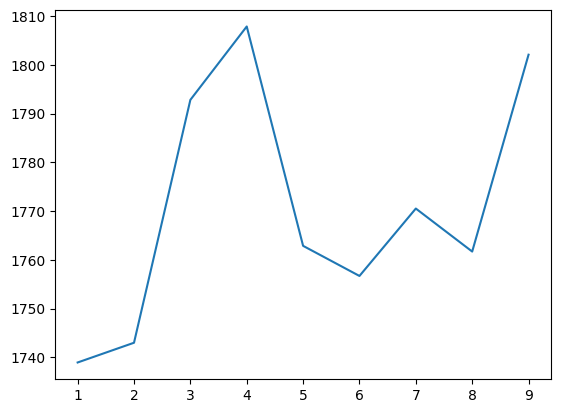

In [225]:
import matplotlib.pyplot as plt
import seaborn as sns

# Podemos graficar la evolución de la perplejidad con las épocas.
# Recordar que el valor de perplejidad del modelo trivial es el tamaño del vocabulario.
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl)
plt.show()

In [226]:
# Cargamos el mejor modelo guardado del entrenamiento para hacer inferencia
model = keras.models.load_model('my_model')

Dado que por problemas con la memoria del GPU tuvimos que usar una base reducida del dataset original (60% del total), se ve que baja la pérdida al inicio pero la perplejidad no. Esto indica overfitting por la falta de datos, dado que el vocabulario también es grande.

Se hicieron varias pruebas y agregando 2 capas de dropout mejoró, sin embargo se sigue evidenciando overfitting por el motivo de no poder procesar el dataset completo.

## Predicción de próxima palabra

In [227]:
"""import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=max_context_size, padding='pre')

    # Predicción softmax
    y_hat = np.argmax(model.predict(encoded)[0,-1,:])


    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text")

iface.launch(debug=True) """

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://2b007a3d1e2ee677b5.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


1/1 [==============================] - 0s 24ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://2b007a3d1e2ee677b5.gradio.live


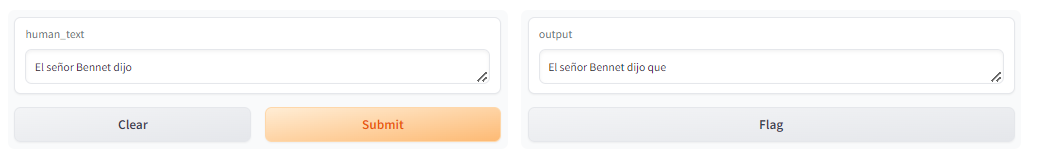

## Generación de secuencias

In [228]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	  # generate a fixed number of words
    for _ in range(n_words):
		  # Tokenizamos
      encoded = tokenizer.texts_to_sequences([output_text])[0]

		  # Si tienen distinto largo
      encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		  # Predicción softmax
      y_hat = np.argmax(model.predict(encoded)[0,-1,:])

      # Vamos concatenando las predicciones
      out_word = ''

      # Debemos buscar en el vocabulario la palabra
      # que corresopnde al indice (y_hat) predicho por le modelo
      for word, index in tokenizer.word_index.items():
        if index == y_hat:
          out_word = word
          break

		  # Agrego las palabras a la frase predicha
      output_text += ' ' + out_word

    return output_text

In [233]:
input_text='El señor Bennet dijo'

generate_seq(model, tok, input_text, max_length=max_context_size, n_words=5)

1/1 [==============================] - 0s 23ms/step


'El señor Bennet dijo que que que que que'

## Beam search

In [234]:
# funcionalidades para hacer encoding y decoding

def encode(text,max_length=max_context_size):

    encoded = tok.texts_to_sequences([text])[0]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return tok.sequences_to_texts([seq])

In [235]:
from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp,mode):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  if mode == 'det':
    idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  elif mode == 'sto':
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo aleatorio
  else:
    raise ValueError(f'Wrong selection mode. {mode} was given. det and sto are supported.')

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input,temp=1,mode='det'):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = model.predict(encoded,verbose=0)[0,-1,:]

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens,
                                        temp,
                                        mode)

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = model.predict(input_update,verbose=0)[0,-1,:]

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens,
                                                        temp,
                                                        mode)

    return history_tokens

In [239]:
# predicción con beam search.
# 'det' (determinista)
# 'sto' (estocástico)
# para el caso estocástico también se puede variar la temperatura
salidas = beam_search(model,num_beams=10,num_words=6,input="El señor Bennet dijo",temp=2,mode='sto')

In [240]:
# tenemos `num_beams` salidas ordenadas de mayor a menor likelihood
salidas.shape

(10, 20)

In [241]:
# veamos las salidas
decode(salidas[0])

['el señor bennet dijo con que hacía nuestra razones lugar']

El modelo repetía mucho qué, pero con Bean search estocástico y colocándole una temperatura de 2, comienza a dar mejores resultados.

A continuación probaremos con GRU.

## Modelo 2: GRU

In [243]:
from keras.layers import GRU

In [244]:
model = Sequential()

# la primera capa es de embedding entrenable. Recordar que se puede variar el tamaño
# del embedding a entrenar
model.add(Embedding(input_dim=vocab_size+1, output_dim=50, input_shape=(None,)))

model.add(GRU(100, return_sequences=True))
model.add(Dropout(0.2))

model.add(GRU(100, return_sequences=True))
model.add(Dropout(0.2))
#model.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax
# La salida es del tamaño del vocabulario
model.add(Dense(vocab_size+1, activation='softmax'))


# Clasificación multiple categórica --> loss = categorical_crossentropy
# notar que usamos la versión Sparse para utilizar sólo índices en lugar de OHE
model.compile(loss=SparseCategoricalCrossentropy(), optimizer='rmsprop')

model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, None, 50)          528700    
                                                                 
 gru (GRU)                   (None, None, 100)         45600     
                                                                 
 dropout_9 (Dropout)         (None, None, 100)         0         
                                                                 
 gru_1 (GRU)                 (None, None, 100)         60600     
                                                                 
 dropout_10 (Dropout)        (None, None, 100)         0         
                                                                 
 dense_18 (Dense)            (None, None, 10574)       1067974   
                                                                 
Total params: 1702874 (6.50 MB)
Trainable params: 170

In [245]:
# fiteamos
history_ppl = []
hist = model.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl)], batch_size=64)

Epoch 1/20
366/366 [==============================] - ETA: 0s - loss: 6.6274
 mean perplexity: 1627.2698047851463 

Saved new model!
366/366 [==============================] - 22s 48ms/step - loss: 6.6274
Epoch 2/20
366/366 [==============================] - ETA: 0s - loss: 6.3036
 mean perplexity: 1680.8201437760188 

366/366 [==============================] - 9s 24ms/step - loss: 6.3036
Epoch 3/20
366/366 [==============================] - ETA: 0s - loss: 6.2975
 mean perplexity: 1739.9221260624342 

366/366 [==============================] - 9s 24ms/step - loss: 6.2975
Epoch 4/20
364/366 [============================>.] - ETA: 0s - loss: 6.2953
 mean perplexity: 1717.6522305792364 

366/366 [==============================] - 8s 23ms/step - loss: 6.2956
Epoch 5/20
366/366 [==============================] - ETA: 0s - loss: 6.2947
 mean perplexity: 1744.2853802045208 

366/366 [==============================] - 8s 23ms/step - loss: 6.2947
Epoch 6/20
365/366 [===========================

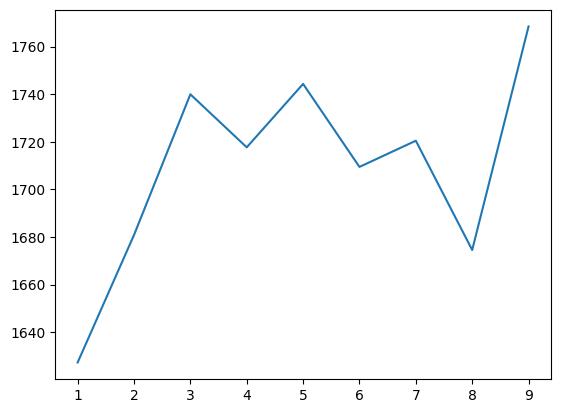

In [246]:
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl)
plt.show()

In [249]:
# Generación de secuencia

input_text='El señor Bennet dijo'

generate_seq(model, tok, input_text, max_length=max_context_size, n_words=5)

1/1 [==============================] - 0s 21ms/step


'El señor Bennet dijo de de de de de'

Le pasa igual que se queda pegado a una palabra común

In [250]:
# predicción con beam search.
# 'det' (determinista)
# 'sto' (estocástico)
# para el caso estocástico también se puede variar la temperatura
salidas = beam_search(model,num_beams=10,num_words=6,input="El señor Bennet dijo",temp=2,mode='sto')

In [256]:
# veamos las salidas
decode(salidas[0])

['el señor bennet dijo o la por con meses']

En este caso el modelo 1 con LSTM arroja resultados ligeramente mejores, este último ejemplo, aunque la perplejidad que arrojó GRU sea ligeramente más baja.